# Predicting the success of Promotional offer (Classification)

## Business Case:

Apprentice Chef provides gourmet meals which require minimal cooking. They can be ordered through online platform or mobile application. The meals are targeted towards San Francisco working professionals who want to have healthy food but do not have enough time to prepare it. Apprentice Chef has collected customer data over the past year and wants to leverage it to determine if their promotional offer will be a success. We will be build various statistical models centered around this objective and select the best one based on performance.

In [1]:
##############################################################################
""" Classification Modelling - Assignment 2 - Christopher Pramodh"""
##############################################################################

# importing libraries ########################################################
import pandas as pd # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns # enhanced graphical output
import statsmodels.formula.api as smf # predictive modeling with nice outputs
import random as rand # random number generation
import gender_guesser.detector as gender # guess gender based on (given) name
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression#linear regression(scikit-learn)
import sklearn.linear_model # linear models
from sklearn.preprocessing import StandardScaler
# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus 
# packages for Hyperparameter
from sklearn.model_selection import RandomizedSearchCV# hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
# packages for Random forest and GBM
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
##############################################################################
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# specifying file name
file = './Apprentice_Chef_Dataset.xlsx'


# reading the file into Python
apprentice = pd.read_excel(io=file)


In [2]:
##############################################################################
"""                                Loading UDFs                            """ 
##############################################################################

# optimal_neighbors for KNN
##############################################################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


##############################################################################
# visual_cm - for viewing confusion matrix
##############################################################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
# 
##############################################################################
# display_tree
##############################################################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

##############################################################################
# plot_feature_importances - important features in models
##############################################################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))


The customer data collected contains data from 1946 customers. This data provides us 30 features for each customer including revenue. We shall further examine this data.

In [3]:
##############################################################################
"""                          Feature Engineering                           """
##############################################################################
# Feature Engineering 1.1
# formatting and printing the dimensions of the dataset
print(f"""
Size of Original Dataset
------------------------
Observations: {apprentice.shape[0]}
Features:     {apprentice.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946
Features:     30



## Cleaning and Exploring the data:

We have received information that the feature 'LARGEST_ORDER_SIZE' was mislabeled. It should actually be called 'AVERAGE_ORDER_SIZE'. Lets fix it.

In [3]:
# Feature Engineering 1.2
# The column LARGEST_ORDER_SIZE was mislabelled. It is the average order size of the customer.
apprentice = apprentice.rename(columns={'LARGEST_ORDER_SIZE':'AVERAGE_ORDER_SIZE'})

Let us analyze the distribution of the data under each feature so that we can visually classify them as:

Continuous : These features have infinite number of values between two data points, for example time.

Categorical: Unlike continuous features, these have finite groups. They might not be logically ordered.

Discrete: Like categorical, these have distinct groups but they are numeric and are countable.

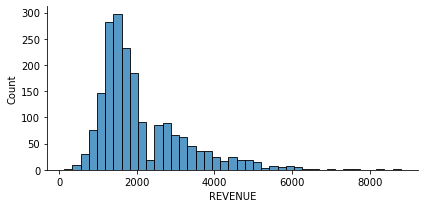

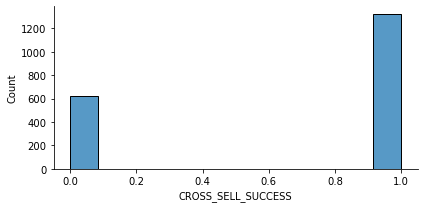

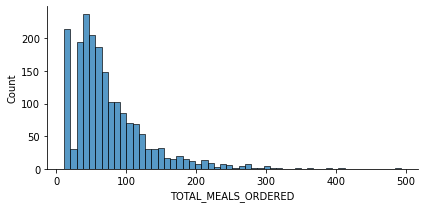

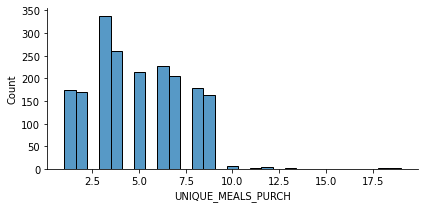

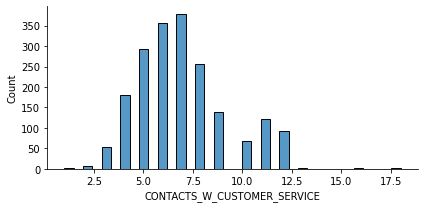

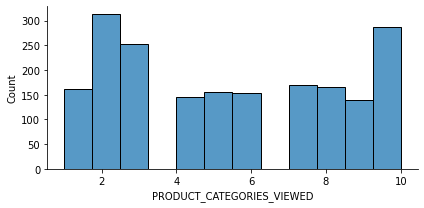

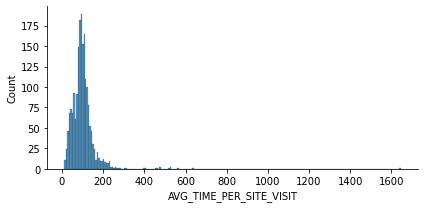

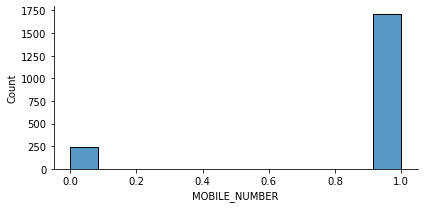

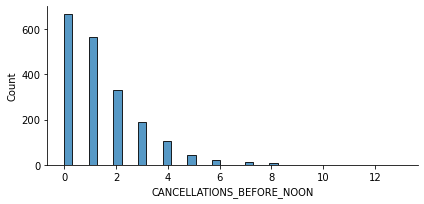

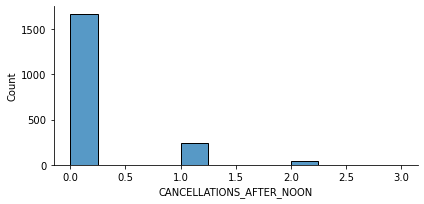

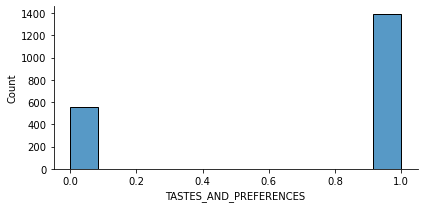

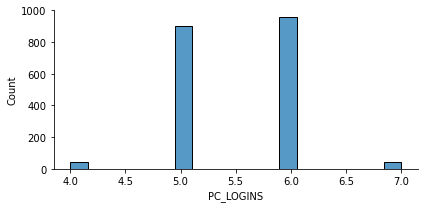

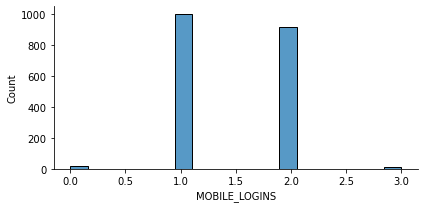

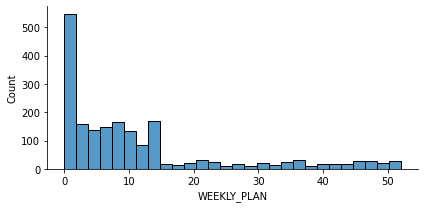

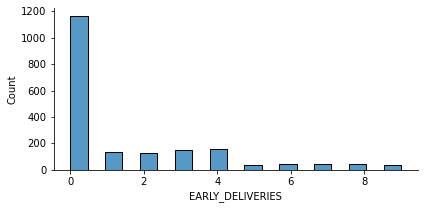

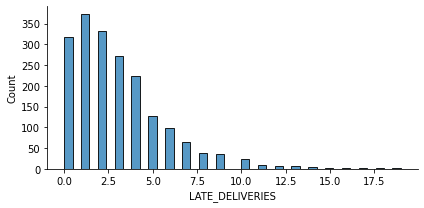

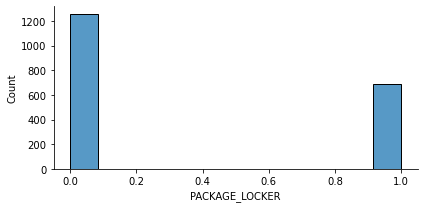

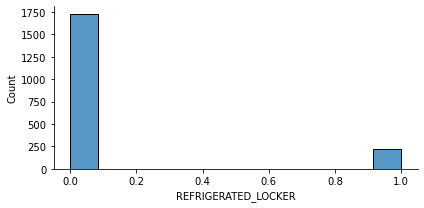

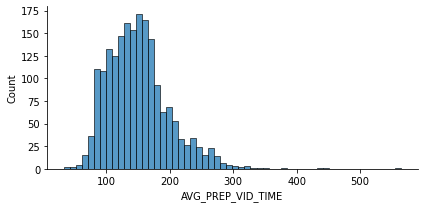

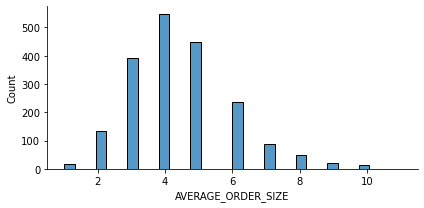

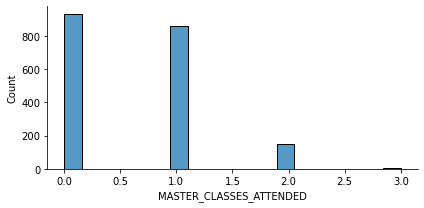

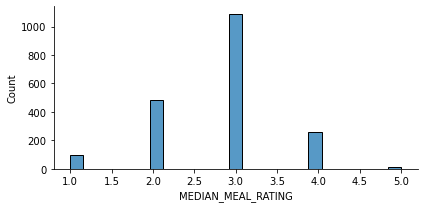

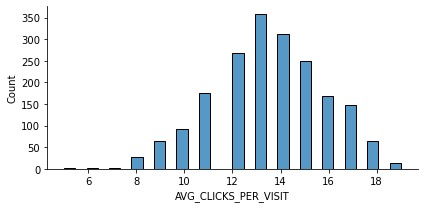

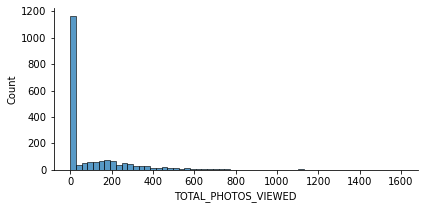

In [4]:
# Feature Engineering 1.3
# Creating a list of column names except for categorical/qualitative
all_variables = ['REVENUE', 'CROSS_SELL_SUCCESS',
                 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
                 'CONTACTS_W_CUSTOMER_SERVICE',  'PRODUCT_CATEGORIES_VIEWED',
                 'AVG_TIME_PER_SITE_VISIT',  'MOBILE_NUMBER', 
                 'CANCELLATIONS_BEFORE_NOON',  'CANCELLATIONS_AFTER_NOON',
                 'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 
                 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
                 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER',  'AVG_PREP_VID_TIME',
                 'AVERAGE_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 
                 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED']

# Creating a loop for finding out the distributions of each feature in all_variables
# This exercise is done to determine if the feature is continuous or an interval
# or even to find skewness for log transformations.

for x in all_variables:
     
    # developing a histogram using DISPLOT
    sns.displot(data   = apprentice,
                x      = apprentice[x],
                height = 3,
               aspect = 2)
    plt.show() 
    
    


Let us analyze the continuous features first. We shall measure the correlation of continuous features with the promotional offer feature (CROSS_SELL_SUCCESS) to identify important features.

The top continuous correlated features are:

    CANCELLATIONS_BEFORE_NOON         0.16
    MOBILE_NUMBER                     0.10
    TASTES_AND_PREFERENCES            0.08
    REFRIGERATED_LOCKER               0.07

In [6]:
# Feature Engineering 1.4
# Feature engineering for Continuos variables
#-----------------------------------------------------------------------------

# creating a list of continuous features (including CROSS_SELL_SUCCESS)
continuous_data = ['REVENUE','CROSS_SELL_SUCCESS','TOTAL_MEALS_ORDERED',
                   'UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',
                   'AVG_TIME_PER_SITE_VISIT','MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
                   'CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES','PC_LOGINS',
                   'MOBILE_LOGINS','EARLY_DELIVERIES','LATE_DELIVERIES','PACKAGE_LOCKER',
                   'REFRIGERATED_LOCKER','AVG_PREP_VID_TIME','AVERAGE_ORDER_SIZE',
                   'AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED']


# developing a correlation matrix based on continuous features
apprentice_corr = apprentice[continuous_data].corr(method = 'pearson')


# filtering the results to only show correlations with CROSS_SELL_SUCCESS
apprentice_corr.loc[ : , 'CROSS_SELL_SUCCESS'].round(decimals = 2).sort_values(ascending = False)

# The top continuous correlated features are: 
""" CANCELLATIONS_BEFORE_NOON         0.16
    MOBILE_NUMBER                     0.10
    TASTES_AND_PREFERENCES            0.08
    REFRIGERATED_LOCKER               0.07"""


' CANCELLATIONS_BEFORE_NOON         0.16\n    MOBILE_NUMBER                     0.10\n    TASTES_AND_PREFERENCES            0.08\n    REFRIGERATED_LOCKER               0.07'

Let us flag all the missing values by creating new columns. The columns will be binary where the observation which has a missing value will be assigned the value of 1.

In [8]:
# Feature Engineering 1.5
# Family name has 47 null values
# looping to detect features with missing values
for col in apprentice:

    # creating columns with 1s if missing and 0 if not
    if apprentice[col].isnull().astype(int).sum() > 0:
        apprentice['m_'+col] = apprentice[col].isnull().astype(int)

#summing the missing value flags to check the results of the loop above
apprentice[    ['m_FAMILY_NAME']    ].sum(axis = 0)

m_FAMILY_NAME    47
dtype: int64

FAMILY_NAME is the only column with missing values. It seems that the family name is fetched from the email. We shall rename these observations as 'Not in Email'.

In [8]:
# Feature Engineering 1.6
# It seems that the last name is fetched from the email.
# Since for the above observations the email does not reflect the last name, we shall
# rename these observations as Not in Email
fill = 'Not in email'
apprentice['FAMILY_NAME'] = apprentice['FAMILY_NAME'].fillna(fill)

In [9]:
# Feature Engineering 1.7 
# Confirming if there are no null values
apprentice.isnull().any().any()

False

We will try to derive more meaning from the FIRST_NAME feature by guessing their gender. We will create a new binary feature for knowing the gender of a customer.

In [10]:
# Feature Engineering 1.8
# Gender Guessing
# guessing gender based on (given) name

# placeholder list
#placeholder_lst = []

# looping to guess gender
#for name in apprentice.loc[:,'FIRST_NAME']:
  #  guess = gender.Detector().get_gender(name)
   # placeholder_lst.append(guess)


# converting list into a series
#apprentice['gender_guess'] = pd.Series(placeholder_lst)


# checking results
#apprentice['gender_guess'].value_counts()

#Creating a list with known male as 1, female as 2 and unknown gender as 0
#placeholder_lst = []

#for val in apprentice['gender_guess']:
  #  if val == 'unknown' or val == 'andy':
   #     placeholder_lst.append(0)
  #  elif val == 'male' or val == 'mostly_male':
  #      placeholder_lst.append(1)
  #  elif val == 'female' or val == 'mostly_female':
  #      placeholder_lst.append(2)
  #  else:
  #      print('Unknown')
   

#print(placeholder_lst)

In [7]:
# Feature Engineering 1.9
# Gender Guessing Part 2
# Known and unknown gender list from gender guesser 
placeholder_lst = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 
                   0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 
                   1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 
                   1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 
                   0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 
                   0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 
                   1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 
                   0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
                   0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 
                   0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,                    
                   1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 
                   1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
                   0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
                   0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 
                   0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 
                   0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 
                   1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,                   
                   1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 
                   0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
                   0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
                   0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 
                   1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 
                   1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 
                   1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 
                   0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 
                   0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 
                   0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 
                   1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 
                   0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 
                   1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 
                   0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 
                   0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 
                   0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 
                   0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
                   0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 
                   0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 
                   0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
                   0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 
                   1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 
                   0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 
                   0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
                   1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 
                   1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 
                   1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
                   1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
                   1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
                   1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 
                   0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 
                   0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
                   0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
                   1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
                   1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
                   1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
                   0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
                   0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
                   0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
                   0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                   1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                   0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
                   0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
                   0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
                   1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 
                   0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
                   0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
                   0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
                   0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                   1, 0, 0, 1, 0, 0]
# Creating a new feature for Known and Unknown genders
apprentice['GENDER_KNOWN'] = pd.Series(placeholder_lst)
apprentice['GENDER_KNOWN'].value_counts()

0    1395
1     551
Name: GENDER_KNOWN, dtype: int64

Though there are no more missing values, there might be features having several observations with zero value. They can misrepresent the data. Let us count the number of zeros in these features.

In [9]:
# Feature Engineering 1.10
# counting the number of zeroes for continuous data variables
REVENUE_zeroes   = len(apprentice['REVENUE'][apprentice['REVENUE']== 0]) # REVENUE
TOTAL_MEALS_ORDERED_zeroes   = len(apprentice['TOTAL_MEALS_ORDERED'][apprentice['TOTAL_MEALS_ORDERED']== 0]) # TOTAL_MEALS_ORDERED
UNIQUE_MEALS_PURCH_zeroes   = len(apprentice['UNIQUE_MEALS_PURCH'][apprentice['UNIQUE_MEALS_PURCH']== 0]) # UNIQUE_MEALS_PURCH
CONTACTS_W_CUSTOMER_SERVICE_zeroes   = len(apprentice['CONTACTS_W_CUSTOMER_SERVICE'][apprentice['CONTACTS_W_CUSTOMER_SERVICE']== 0]) # CONTACTS_W_CUSTOMER_SERVICE
AVG_TIME_PER_SITE_VISIT_zeroes   = len(apprentice['AVG_TIME_PER_SITE_VISIT'][apprentice['AVG_TIME_PER_SITE_VISIT']== 0]) # AVG_TIME_PER_SITE_VISIT
MOBILE_NUMBER_zeroes   = len(apprentice['MOBILE_NUMBER'][apprentice['MOBILE_NUMBER']== 0]) # MOBILE_NUMBER
CANCELLATIONS_BEFORE_NOON_zeroes   = len(apprentice['CANCELLATIONS_BEFORE_NOON'][apprentice['CANCELLATIONS_BEFORE_NOON']== 0]) # CANCELLATIONS_BEFORE_NOON
CANCELLATIONS_AFTER_NOON_zeroes   = len(apprentice['CANCELLATIONS_AFTER_NOON'][apprentice['CANCELLATIONS_AFTER_NOON']== 0]) # CANCELLATIONS_AFTER_NOON
TASTES_AND_PREFERENCES_zeroes   = len(apprentice['TASTES_AND_PREFERENCES'][apprentice['TASTES_AND_PREFERENCES']== 0]) # TASTES_AND_PREFERENCES
PC_LOGINS_zeroes   = len(apprentice['PC_LOGINS'][apprentice['PC_LOGINS']== 0]) # PC_LOGINS
MOBILE_LOGINS_zeroes   = len(apprentice['MOBILE_LOGINS'][apprentice['MOBILE_LOGINS']== 0]) # MOBILE_LOGINS
EARLY_DELIVERIES_zeroes   = len(apprentice['EARLY_DELIVERIES'][apprentice['EARLY_DELIVERIES']== 0]) # EARLY_DELIVERIES
LATE_DELIVERIES_zeroes   = len(apprentice['LATE_DELIVERIES'][apprentice['LATE_DELIVERIES']== 0]) # LATE_DELIVERIES
PACKAGE_LOCKER_zeroes   = len(apprentice['PACKAGE_LOCKER'][apprentice['PACKAGE_LOCKER']== 0]) # PACKAGE_LOCKER
REFRIGERATED_LOCKER_zeroes   = len(apprentice['REFRIGERATED_LOCKER'][apprentice['REFRIGERATED_LOCKER']== 0]) # REFRIGERATED_LOCKER
AVG_PREP_VID_TIME_zeroes   = len(apprentice['AVG_PREP_VID_TIME'][apprentice['AVG_PREP_VID_TIME']== 0]) # AVG_PREP_VID_TIME
AVERAGE_ORDER_SIZE_zeroes   = len(apprentice['AVERAGE_ORDER_SIZE'][apprentice['AVERAGE_ORDER_SIZE']== 0]) # AVERAGE_ORDER_SIZE
#MASTER_CLASSES_ATTENDED_zeroes   = len(apprentice['MASTER_CLASSES_ATTENDED'][apprentice['MASTER_CLASSES_ATTENDED']== 0]) #MASTER_CLASSES_ATTENDED
AVG_CLICKS_PER_VISIT_zeroes   = len(apprentice['AVG_CLICKS_PER_VISIT'][apprentice['AVG_CLICKS_PER_VISIT']== 0]) # AVG_CLICKS_PER_VISIT
TOTAL_PHOTOS_VIEWED_zeroes   = len(apprentice['TOTAL_PHOTOS_VIEWED'][apprentice['TOTAL_PHOTOS_VIEWED']== 0]) # TOTAL_PHOTOS_VIEWED

# printing a table of the results
print(f"""
                                     No\t\tYes
                                   ---------------------
Revenue                            | {REVENUE_zeroes}\t\t{len(apprentice) - REVENUE_zeroes}       
Total Meals Ordered                | {TOTAL_MEALS_ORDERED_zeroes}\t\t{len(apprentice) - TOTAL_MEALS_ORDERED_zeroes}
Unique Meals Purchased             | {UNIQUE_MEALS_PURCH_zeroes}\t\t{len(apprentice) - UNIQUE_MEALS_PURCH_zeroes}
Contacts with Customer Service     | {CONTACTS_W_CUSTOMER_SERVICE_zeroes }\t\t{len(apprentice) - CONTACTS_W_CUSTOMER_SERVICE_zeroes }
Avg Time per Site Visit            | {AVG_TIME_PER_SITE_VISIT_zeroes}\t\t{len(apprentice) - AVG_TIME_PER_SITE_VISIT_zeroes}
Mobile No.(binary)                 | {MOBILE_NUMBER_zeroes}\t{len(apprentice) - MOBILE_NUMBER_zeroes}
Cancellations Before Noon          | {CANCELLATIONS_BEFORE_NOON_zeroes}\t{len(apprentice) - CANCELLATIONS_BEFORE_NOON_zeroes}
Cancellations After Noon           | {CANCELLATIONS_AFTER_NOON_zeroes}\t{len(apprentice) - CANCELLATIONS_AFTER_NOON_zeroes}
Tastes and Preferences(binary)     | {TASTES_AND_PREFERENCES_zeroes}\t{len(apprentice) - TASTES_AND_PREFERENCES_zeroes}
PC Logins                          | {PC_LOGINS_zeroes}\t\t{len(apprentice) - PC_LOGINS_zeroes}
Mobile Logins                      | {MOBILE_LOGINS_zeroes}\t\t{len(apprentice) - MOBILE_LOGINS_zeroes}
Early Deliveries                   | {EARLY_DELIVERIES_zeroes}\t{len(apprentice) - EARLY_DELIVERIES_zeroes}
Late Deliveries                    | {LATE_DELIVERIES_zeroes}\t{len(apprentice) - LATE_DELIVERIES_zeroes}
Package Locker(binary)             | {PACKAGE_LOCKER_zeroes}\t{len(apprentice) - PACKAGE_LOCKER_zeroes}
Refrigerated Locker(binary)        | {REFRIGERATED_LOCKER_zeroes}\t{len(apprentice) - REFRIGERATED_LOCKER_zeroes}
Avg Prep Vid Time                  | {AVG_PREP_VID_TIME_zeroes}\t\t{len(apprentice) - AVG_PREP_VID_TIME_zeroes}
Avg Order Size                     | {AVERAGE_ORDER_SIZE_zeroes}\t\t{len(apprentice) - AVERAGE_ORDER_SIZE_zeroes}
Avg Clicks per Visit               | {AVG_CLICKS_PER_VISIT_zeroes}\t\t{len(apprentice) - AVG_CLICKS_PER_VISIT_zeroes}
Total Photos Viewed                | {TOTAL_PHOTOS_VIEWED_zeroes}\t{len(apprentice) - TOTAL_PHOTOS_VIEWED_zeroes}
  
""")




                                     No		Yes
                                   ---------------------
Revenue                            | 0		1946       
Total Meals Ordered                | 0		1946
Unique Meals Purchased             | 0		1946
Contacts with Customer Service     | 0		1946
Avg Time per Site Visit            | 0		1946
Mobile No.(binary)                 | 238	1708
Cancellations Before Noon          | 667	1279
Cancellations After Noon           | 1667	279
Tastes and Preferences(binary)     | 556	1390
PC Logins                          | 0		1946
Mobile Logins                      | 16		1930
Early Deliveries                   | 1167	779
Late Deliveries                    | 319	1627
Package Locker(binary)             | 1255	691
Refrigerated Locker(binary)        | 1726	220
Avg Prep Vid Time                  | 0		1946
Avg Order Size                     | 0		1946
Avg Clicks per Visit               | 0		1946
Total Photos Viewed                | 1140	806
  



In [10]:
# Feature Engineering 1.11
# Creating dummy variables for non-binary continuous data. 
apprentice['has_CANCELLATIONS_BEFORE_NOON']   = 0
apprentice['has_CANCELLATIONS_AFTER_NOON']   = 0
apprentice['has_MOBILE_LOGINS']   = 0
apprentice['has_EARLY_DELIVERIES']   = 0
apprentice['has_LATE_DELIVERIES']   = 0
apprentice['has_TOTAL_PHOTOS_VIEWED']   = 0

# iterating over each original column to
# change values in the new feature columns
for index, value in apprentice.iterrows():    
         
    # CANCELLATIONS_BEFORE_NOON
    if apprentice.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0:
        apprentice.loc[index, 'has_CANCELLATIONS_BEFORE_NOON'] = 1
        
    # CANCELLATIONS_AFTER_NOON
    if apprentice.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
        apprentice.loc[index, 'has_CANCELLATIONS_AFTER_NOON'] = 1        
      
    # MOBILE_LOGINS
    if apprentice.loc[index, 'MOBILE_LOGINS'] > 0:
        apprentice.loc[index, 'has_MOBILE_LOGINS'] = 1
        
    # EARLY_DELIVERIES
    if apprentice.loc[index, 'EARLY_DELIVERIES'] > 0:
        apprentice.loc[index, 'has_EARLY_DELIVERIES'] = 1
        
    # LATE_DELIVERIES
    if apprentice.loc[index, 'LATE_DELIVERIES'] > 0:
        apprentice.loc[index, 'has_LATE_DELIVERIES'] = 1
        
         
    # TOTAL_PHOTOS_VIEWED
    if apprentice.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        apprentice.loc[index, 'has_TOTAL_PHOTOS_VIEWED'] = 1
        
   

Out of the new columns created, has_CANCELLATIONS_BEFORE_NOON has top correlation of 0.138611.

In [14]:
# Feature Engineering 1.12
# developing a small correlation matrix for apprentice dataset
zeroes_corr = apprentice.corr()    # .round(decimals = 2)


# checking the correlations of the newly-created variables with CROSS_SELL_SUCCESS
zeroes_corr.loc['CROSS_SELL_SUCCESS',                                   # Y-variable
               ['has_CANCELLATIONS_BEFORE_NOON', 'has_CANCELLATIONS_AFTER_NOON', 
                'has_MOBILE_LOGINS','has_EARLY_DELIVERIES',
               'has_LATE_DELIVERIES','has_TOTAL_PHOTOS_VIEWED']].sort_values(ascending = False)

# has_CANCELLATIONS_BEFORE_NOON has top correlation of 0.138611.



has_CANCELLATIONS_BEFORE_NOON    0.138611
has_TOTAL_PHOTOS_VIEWED          0.010868
has_MOBILE_LOGINS                0.010496
has_LATE_DELIVERIES              0.001624
has_EARLY_DELIVERIES            -0.006306
has_CANCELLATIONS_AFTER_NOON    -0.045200
Name: CROSS_SELL_SUCCESS, dtype: float64

Let us identify if there are any skewed features so that we can make them more uniform using log transformations.

In [15]:
# Feature Engineering 1.13
# checking for skewness so that we know whether to log tranform variables or not
apprentice.skew(axis=0)


Unnamed: 0                        0.000000
REVENUE                           1.626573
CROSS_SELL_SUCCESS               -0.766572
TOTAL_MEALS_ORDERED               2.006653
UNIQUE_MEALS_PURCH                0.370833
CONTACTS_W_CUSTOMER_SERVICE       0.566015
PRODUCT_CATEGORIES_VIEWED         0.163797
AVG_TIME_PER_SITE_VISIT           9.639388
MOBILE_NUMBER                    -2.307384
CANCELLATIONS_BEFORE_NOON         1.601525
CANCELLATIONS_AFTER_NOON          2.760535
TASTES_AND_PREFERENCES           -0.949415
PC_LOGINS                        -0.038384
MOBILE_LOGINS                     0.052285
WEEKLY_PLAN                       1.538602
EARLY_DELIVERIES                  1.603124
LATE_DELIVERIES                   1.513355
PACKAGE_LOCKER                    0.606112
REFRIGERATED_LOCKER               2.445841
AVG_PREP_VID_TIME                 1.200283
AVERAGE_ORDER_SIZE                0.703995
MASTER_CLASSES_ATTENDED           0.657373
MEDIAN_MEAL_RATING               -0.253768
AVG_CLICKS_

There are many skewed features. AVG_TIME_PER_SITE_VISIT is skewed at 9.639388. We will log transform all the variables which have a skewness of 2.0 or above

In [16]:
# Feature Engineering 1.14
# AVG_TIME_PER_SITE_VISIT is skewed at 9.639388 
# Hence we shall log transform any variable(which allows us to do so) with skewness of 2 or above
apprentice['log_AVG_TIME_PER_SITE_VISIT'] = np.log10(apprentice['AVG_TIME_PER_SITE_VISIT'])
apprentice['log_TOTAL_MEALS_ORDERED'] = np.log10(apprentice['TOTAL_MEALS_ORDERED'])
apprentice['log_REVENUE'] = np.log10(apprentice['REVENUE'])
apprentice['log_AVG_CLICKS_PER_VISIT'] = np.log10(apprentice['AVG_CLICKS_PER_VISIT'])




We have received information from our business case that email domains have the potential to influence revenue. Hence let us identify and categorize the various emails in the dataset and call the feature as 'domain_group'. It will be a discrete variable with values '0' for junk emails, '1' for personal emails and '2' for professional emails.

In [17]:
# Feature Engineering 1.15
# Lets try to derive more meaning from the EMAIL variable

# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in apprentice.iterrows():
    
    # splitting email domain at '@'
    split_email = apprentice.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# displaying the results
email_df

,0,1
0,saathos,unitedhealth.com
1,alysanne.osgrey,ge.org
2,edwyd.fossoway,jnj.com
3,eleyna.westerling,ge.org
4,elyn.norridge,jnj.com
...,...,...
1941,obara.sand,yahoo.com
1942,quentyn.blackwood,yahoo.com
1943,rhonda.rowan,gmail.com
1944,turnip,yahoo.com


In [18]:
# Feature Engineering 1.16
# renaming column to concatenate
email_df.columns = ['0' , 'personal_email_domain']


# concatenating personal_email_domain with apprentice DataFrame
apprentice = pd.concat([apprentice, email_df],
                   axis = 1)


# printing value counts of personal_email_domain
apprentice.loc[: ,'personal_email_domain'].value_counts()

gmail.com           303
protonmail.com      284
yahoo.com           274
msn.com              72
aol.com              69
passport.com         64
hotmail.com          63
live.com             62
me.com               59
amex.com             30
jnj.com              28
merck.com            28
mcdonalds.com        28
cocacola.com         28
nike.com             27
apple.com            27
ibm.com              26
ge.org               26
dupont.com           26
chevron.com          25
microsoft.com        25
travelers.com        24
unitedhealth.com     24
exxon.com            24
boeing.com           23
verizon.com          22
pg.com               22
caterpillar.com      22
mmm.com              22
walmart.com          21
disney.com           21
visa.com             20
pfizer.com           20
jpmorgan.com         19
cisco.com            18
unitedtech.com       18
goldmansacs.com      18
intel.com            17
homedepot.com        17
Name: personal_email_domain, dtype: int64

In [19]:
#Feature Engineering 1.17
# email domain types

pers_email_domains = [ '@gmail.com','@protonmail.com','@yahoo.com']



professional_email_domains  = [ '@merck.com','@mcdonalds.com','@cocacola.com',
                       '@jnj.com',  '@apple.com','@amex.com','@visa.com',
                       '@nike.com', '@dupont.com','@ge.org', '@ibm.com',
                         '@microsoft.com','@chevron.com','@travelers.com',
                            '@unitedhealth.com','@exxon.com', '@boeing.com','@mmm.com', '@pg.com',
                       '@caterpillar.com', '@verizon.com','@disney.com', '@walmart.com',
                         '@pfizer.com','@jpmorgan.com', '@cisco.com',
                         '@unitedtech.com', '@goldmansacs.com','@intel.com', 
                          '@homedepot.com']


junk_email_domains = ['@passport.com','@me.com','@msn.com',
                       '@aol.com','@hotmail.com','@live.com']
# placeholder list
placeholder_lst = []

# Lets create a dummy variable to differentiate between normal email domains
# and different email domains
# looping to group observations by domain type
for domain in apprentice['personal_email_domain']:
        if '@'+ domain in junk_email_domains:
            placeholder_lst.append(0)
            
        elif '@'+ domain in pers_email_domains:
            placeholder_lst.append(1)
        elif '@'+ domain in professional_email_domains:
            placeholder_lst.append(2)
        elif '@'+ domain in gmail:
            placeholder_lst.append(3)
                  
        else:
            print('Unknown')


# concatenating with original DataFrame
apprentice['domain_group'] = pd.Series(placeholder_lst)


# checking results
apprentice['domain_group'].value_counts()

1    861
2    696
0    389
Name: domain_group, dtype: int64

Let us create another feature which measures the number of names in each customer's full name.

In [20]:
# Feature Engineering 1.171
# Creating a variables with the length of each customer's name
text_split_feature(col = 'NAME', df = apprentice, sep = ' ', new_col_name ='NUMBER_OF_NAMES')


Finally, let us check the correlation with all the features that we have created.

In [21]:
# Feature Engineering 1.18
# creating a (Pearson) correlation matrix
df_corr = apprentice.corr().round(2)


# printing (Pearson) correlations with SalePrice
print(df_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False))

CROSS_SELL_SUCCESS               1.00
domain_group                     0.28
NUMBER_OF_NAMES                  0.16
CANCELLATIONS_BEFORE_NOON        0.16
has_CANCELLATIONS_BEFORE_NOON    0.14
MOBILE_NUMBER                    0.10
TASTES_AND_PREFERENCES           0.08
REFRIGERATED_LOCKER              0.07
GENDER_KNOWN                     0.05
PACKAGE_LOCKER                   0.04
CONTACTS_W_CUSTOMER_SERVICE      0.04
MASTER_CLASSES_ATTENDED          0.04
PC_LOGINS                        0.04
MEDIAN_MEAL_RATING               0.03
AVG_PREP_VID_TIME                0.03
EARLY_DELIVERIES                 0.02
log_TOTAL_MEALS_ORDERED          0.02
AVERAGE_ORDER_SIZE               0.02
log_AVG_TIME_PER_SITE_VISIT      0.02
m_FAMILY_NAME                    0.02
has_MOBILE_LOGINS                0.01
TOTAL_MEALS_ORDERED              0.01
log_REVENUE                      0.01
AVG_TIME_PER_SITE_VISIT          0.01
has_TOTAL_PHOTOS_VIEWED          0.01
TOTAL_PHOTOS_VIEWED              0.01
LATE_DELIVER

## Building classification models

We will use logit model to identify the statistically significant variables.

In [22]:
##############################################################################
"""             Building a full model using statsmodels                    """
##############################################################################
# looping to make x-variables suitable for statsmodels
for val in apprentice:
    print(f"{val} +")


Unnamed: 0 +
REVENUE +
CROSS_SELL_SUCCESS +
NAME +
EMAIL +
FIRST_NAME +
FAMILY_NAME +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
CONTACTS_W_CUSTOMER_SERVICE +
PRODUCT_CATEGORIES_VIEWED +
AVG_TIME_PER_SITE_VISIT +
MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +
CANCELLATIONS_AFTER_NOON +
TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
AVG_PREP_VID_TIME +
AVERAGE_ORDER_SIZE +
MASTER_CLASSES_ATTENDED +
MEDIAN_MEAL_RATING +
AVG_CLICKS_PER_VISIT +
TOTAL_PHOTOS_VIEWED +
m_FAMILY_NAME +
GENDER_KNOWN +
has_CANCELLATIONS_BEFORE_NOON +
has_CANCELLATIONS_AFTER_NOON +
has_MOBILE_LOGINS +
has_EARLY_DELIVERIES +
has_LATE_DELIVERIES +
has_TOTAL_PHOTOS_VIEWED +
log_AVG_TIME_PER_SITE_VISIT +
log_TOTAL_MEALS_ORDERED +
log_REVENUE +
log_AVG_CLICKS_PER_VISIT +
0 +
personal_email_domain +
domain_group +
NUMBER_OF_NAMES +


In [23]:
#Statsmodels 1.1
##########Identifying significant variables for model building

# Step 1: build a model
lm_best = smf.logit(formula =  """CROSS_SELL_SUCCESS ~  TOTAL_MEALS_ORDERED +
                                                        CONTACTS_W_CUSTOMER_SERVICE +
                                                        MOBILE_NUMBER +
                                                        CANCELLATIONS_BEFORE_NOON +
                                                        CANCELLATIONS_AFTER_NOON +
                                                        TASTES_AND_PREFERENCES +
                                                        PC_LOGINS +                                                                         
                                                        REFRIGERATED_LOCKER +
                                                        GENDER_KNOWN +                                                     
                                                        log_TOTAL_MEALS_ORDERED +
                                                        log_REVENUE +
                                                        NUMBER_OF_NAMES +
                                                        domain_group""",
                                data = apprentice)


# Step 2: fit the model based on the data
results = lm_best.fit()



# Step 3: analyze the summary output
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.536273
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1946
Model:                          Logit   Df Residuals:                     1932
Method:                           MLE   Df Model:                           13
Date:                Wed, 27 Jan 2021   Pseudo R-squ.:                  0.1457
Time:                        16:24:54   Log-Likelihood:                -1043.6
converged:                       True   LL-Null:                       -1221.6
Covariance Type:            nonrobust   LLR p-value:                 4.183e-68
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.6237      1.189     -3.889      0.000   

In [24]:
#Statsmodels 1.2
# Creating two lists with all variables and significant variables.

logit_full = ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
              'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 
              'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 
              'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS',              
              'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
              'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME', 'AVERAGE_ORDER_SIZE', 
              'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 
              'TOTAL_PHOTOS_VIEWED', 'm_FAMILY_NAME', 'has_CANCELLATIONS_BEFORE_NOON', 
              'has_CANCELLATIONS_AFTER_NOON', 'has_MOBILE_LOGINS','GENDER_KNOWN','has_EARLY_DELIVERIES', 
              'has_LATE_DELIVERIES', 'has_TOTAL_PHOTOS_VIEWED', 'log_AVG_TIME_PER_SITE_VISIT', 
              'log_TOTAL_MEALS_ORDERED', 'log_REVENUE', 'log_AVG_CLICKS_PER_VISIT', 
               'domain_group','NUMBER_OF_NAMES']


logit_sig = ['TOTAL_MEALS_ORDERED', 'CONTACTS_W_CUSTOMER_SERVICE', 'MOBILE_NUMBER',
             'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 
             'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'has_MOBILE_LOGINS', 
              'REFRIGERATED_LOCKER', 'GENDER_KNOWN', 'MOBILE_LOGINS',   
              'log_TOTAL_MEALS_ORDERED', 'has_CANCELLATIONS_BEFORE_NOON',
             'log_REVENUE', 'domain_group','NUMBER_OF_NAMES']

apprentice_data = apprentice.loc[:,logit_full]
apprentice_target = apprentice.loc[:,'CROSS_SELL_SUCCESS']


We scale all our features so that they are standardized and can be more easily compared with other features.

In [25]:
##############################################################################
"""                     Further Feature Engineering                        """
##############################################################################
#Scaling variables - Significant

# INSTANTIATING StandardScaler()
scaler = StandardScaler()

# FITTING the data
scaler.fit(apprentice_data)


# TRANSFORMING the data
x_scaled = scaler.transform(apprentice_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled)
x_scaled_df.columns = apprentice_data.columns
x_scaled_df['CROSS_SELL_SUCCESS'] = apprentice.loc[:,'CROSS_SELL_SUCCESS']

# Saving scaled x variables
apprentice_data_scaled = x_scaled_df.loc[:,logit_sig]
apprentice_data_scaled_full = x_scaled_df.loc[:,logit_full]

Now our dataset is ready for building models. We shall split the data into training and testing sets. We will build our model on the training set. We shall split the data twice. The first training-testing set will contain only statistically significant features, i.e, they have a p-value below 0.05. The second training-testing set will contain all the features of the dataset. We will use CROSS_SELL_SUCCESS as our dependent variable.

In [26]:
##############################################################################
"""                         Train & Test Split                             """
##############################################################################
# Splitting data using scaled x variables and CROSS SELL SUCCESS

x_train, x_test, y_train, y_test = train_test_split(
            apprentice_data_scaled,
            apprentice_target,
            random_state = 219,
            test_size = 0.25,
            stratify =apprentice_target )


x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(
            apprentice_data_scaled_full,
            apprentice_target,
            random_state = 219,
            test_size = 0.25,
            stratify =apprentice_target )

1) For our first model, we will run K Nearest Neighbors using statistically significant features and CROSS_SELL_SUCCESS as our dependent variable. 

In [27]:
##############################################################################
"""                      K Nearest Neighbors Model                         """
##############################################################################

# Importing necessary libraries for KNN
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Finding the optimal neighbors using UDF optimal_neighbors
opt_neighbors= optimal_neighbors(x_data=apprentice_data_scaled,
                      y_data=apprentice_target,
                      standardize = False,
                      pct_test=0.25,
                      seed=219,
                      response_type='class',
                      max_neighbors=20,
                      show_viz=False)

The optimal number of neighbors is: 18


In [28]:
# KNN 1.1
# KNN scaled

# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train, y_train)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train, y_train).round(4)
knn_test_score  = knn_fit.score(x_test, y_test).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.7306
Testing  ACCURACY: 0.7228
AUC Score        : 0.5978


In [29]:
# KNN 1.2
# importing necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
# unpacking the confusion matrix
KNN_tree_tn, \
KNN_tree_fp, \
KNN_tree_fn, \
KNN_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {KNN_tree_tn}
False Positives: {KNN_tree_fp}
False Negatives: {KNN_tree_fn}
True Positives : {KNN_tree_tp}
""")

KNN = [KNN_tree_tn,
KNN_tree_fp,
KNN_tree_fn,
KNN_tree_tp]


True Negatives : 39
False Positives: 117
False Negatives: 18
True Positives : 313



2) For our second model, we will run logistic regression using statistically significant features and CROSS_SELL_SUCCESS as our dependent variable. 

In [30]:
##############################################################################
"""               Logistic Regression in scikit learn                      """
##############################################################################
# Importing necessary libraries for logistic regression

from sklearn.linear_model import LogisticRegression

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy
# area under the roc curve (auc)
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

Training ACCURACY: 0.7395
Testing  ACCURACY: 0.7536
0.6747


In [31]:
# Logistic Regression 1.2
# importing necessary libraries for confusion matrix

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

logreg_con = [logreg_tn,
logreg_fp,
logreg_fn,
logreg_tp]


True Negatives : 71
False Positives: 85
False Negatives: 35
True Positives : 296



3) For our third model, we will run a Decision Tree Model using statistically significant features and CROSS_SELL_SUCCESS as our dependent variable. 

In [32]:
##############################################################################
"""                         Decision Tree Model                            """
##############################################################################

# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth=3,
                    min_samples_leaf=25,
                    random_state = 219)


# FITTING the training data
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pred).round(4) # auc

Training ACCURACY: 0.7375
Testing  ACCURACY: 0.7598
AUC Score        : 0.7267


In [33]:
# Decision Tree 1.1
# importing necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")

pruned_tree = [pruned_tree_tn,
pruned_tree_fp,
pruned_tree_fn,
pruned_tree_tp]


True Negatives : 99
False Positives: 57
False Negatives: 60
True Positives : 271



In [34]:
# Decision tree 1.2
# calling display_tree
#display_tree(tree       = tree_pruned_fit,
 #            feature_df = x_train)

In [35]:
# Decision Tree 1.4
# plotting feature importance
#plot_feature_importances(tree_pruned_fit,
#                         train  = x_train,
#                         export = False)

4) & 5) For our fourth and fifth models, we will rerun our Logistic Regression after Hyperparameter tuning. We will apply the model with statistically significant features and also the full dataset having CROSS_SELL_SUCCESS as our dependent variable. 

In [36]:
# ###########################################################################
"""           Hyperparameter Tuning for Logistic Regression             """
##############################################################################

# RandomizedSearchCV for Logistic Regression
############################################

# declaring a hyperparameter space
#C_space          = [2]
#warm_start_space = [True]
#solver_space     = ['lbfgs','newton-cg','sag']


# creating a hyperparameter grid
#param_grid = {'C'          : C_space,
             # 'warm_start' : warm_start_space,
              #'solver'     : solver_space}


# INSTANTIATING the model object without hyperparameters
#lr_tuned = LogisticRegression(random_state = 219,
                             # max_iter     = 1000)


# GridSearchCV object
#lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                # param_distributions = param_grid, # parameters to tune
                                # cv                  = 3,          # how many folds in cross-validation
                                # n_iter              = 500,        # number of combinations of hyperparameters to try
                                # random_state        = 219,        # starting point for random sequence
                                # scoring = make_scorer(
                                      #     roc_auc_score,
                                       #    needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
#lr_tuned_cv.fit(apprentice_data_scaled, apprentice_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", lr_tuned_cv.best_params_)
#print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

'           Hyperparameter Tuning for Logistic Regression             '

In [37]:
# Hyperparameter 1.1
# checking the best estimator for the model
#lr_tuned_cv.best_estimator_

In [38]:
# Hyperparameter 1.2
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C=2, max_iter=1000, random_state=219, warm_start=True)


# FIT step is not needed
lr_tuned.fit(apprentice_data_scaled, apprentice_target)

# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                  y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

Training ACCURACY: 0.743
Testing  ACCURACY: 0.7536
AUC Score        : 0.6713


In [39]:
# Hyperparameter 1.3
# building a model based on hyperparameter tuning results (full)

# INSTANTIATING a logistic regression model with tuned values
lr_tuned_full = LogisticRegression(C=2, max_iter=1000, random_state=219, warm_start=True)


# FIT step is not needed
lr_tuned_full.fit(apprentice_data_scaled_full, apprentice_target)

# PREDICTING based on the testing set
lr_tuned_pred_full = lr_tuned_full.predict(x_test_full)


# SCORING the results
print('Training ACCURACY:', lr_tuned_full.score(x_train_full, y_train_full).round(4))
print('Testing  ACCURACY:', lr_tuned_full.score(x_test_full, y_test_full).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_full,
                                  y_score = lr_tuned_pred_full).round(4))


# saving scoring data for future use
lr_tuned_train_score_full = lr_tuned_full.score(x_train_full, y_train_full).round(4) # accuracy
lr_tuned_test_score_full  = lr_tuned_full.score(x_test_full, y_test_full).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc_full         = roc_auc_score(y_true  = y_test_full,
                                     y_score = lr_tuned_pred_full).round(4) # auc

Training ACCURACY: 0.7471
Testing  ACCURACY: 0.7618
AUC Score        : 0.679


In [40]:
# Logistic Regression Tuned 1.2
# importing necessary libraries for confusion matrix

# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")

lr_tuned_con = [lr_tuned_tn,
lr_tuned_fp,
lr_tuned_fn,
lr_tuned_tp]


True Negatives : 69
False Positives: 87
False Negatives: 33
True Positives : 298



In [41]:
# Logistic Regression Tuned 1.2
# importing necessary libraries for confusion matrix

# unpacking the confusion matrix
lr_tuned_tn_full, \
lr_tuned_fp_full, \
lr_tuned_fn_full, \
lr_tuned_tp_full = confusion_matrix(y_true = y_test_full, y_pred = lr_tuned_pred_full).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn_full}
False Positives: {lr_tuned_fp_full}
False Negatives: {lr_tuned_fn_full}
True Positives : {lr_tuned_tp_full}
""")

lr_tuned_con_full = [lr_tuned_tn_full,
lr_tuned_fp_full,
lr_tuned_fn_full,
lr_tuned_tp_full]


True Negatives : 70
False Positives: 86
False Negatives: 30
True Positives : 301



6) & 7) For our sixth and seventh models, we will rerun our Decision tree model after Hyperparameter tuning. We will apply the model with statistically significant features and also the full dataset having CROSS_SELL_SUCCESS as our dependent variable. 

In [42]:
# ###########################################################################
"""           Hyperparameter Tuning for Decision Tree             """
##############################################################################

# declaring a hyperparameter space
#criterion_space = ['gini', 'entropy']
#splitter_space  = ['best', 'random']
#depth_space     = pd.np.arange(1, 25, 1)
#leaf_space      = pd.np.arange(1, 100, 1)


# creating a hyperparameter grid
#param_grid = {'criterion'        : criterion_space,
              #'splitter'         : splitter_space,
             # 'max_depth'        : depth_space,
             # 'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
#tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
#tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                  # param_distributions   = param_grid,
                                  # cv                    = 3,
                                  # n_iter                = 1000,
                                  # random_state          = 219,
                                 #  scoring = make_scorer(roc_auc_score,
                                            # needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#tuned_tree_cv.fit(apprentice_data_scaled, apprentice_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", tuned_tree_cv.best_params_)
#print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

'           Hyperparameter Tuning for Decision Tree             '

In [43]:
# Hyper Tree 1.1 
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(splitter = 'best', criterion = 'gini',max_depth=17,
                                    min_samples_leaf=30, random_state=219)


# FIT step is not needed
tree_tuned.fit(x_train, y_train)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7629
Testing  ACCURACY: 0.731
AUC Score        : 0.653


In [44]:
# Hyper Tree 1.11 
# building a model based on hyperparameter tuning results (full)

# INSTANTIATING a logistic regression model with tuned values
tree_tuned_full = DecisionTreeClassifier(splitter = 'best', criterion = 'gini',max_depth=17,
                                    min_samples_leaf=30, random_state=219)


# FIT step is not needed
tree_tuned_full.fit(apprentice_data_scaled_full, apprentice_target)

# PREDICTING based on the testing set
tree_tuned_pred_full = tree_tuned_full.predict(x_test_full)


# SCORING the results
print('Training ACCURACY:', tree_tuned_full.score(x_train_full, y_train_full).round(4))
print('Testing  ACCURACY:', tree_tuned_full.score(x_test_full, y_test_full).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_full,
                                          y_score = tree_tuned_pred_full).round(4))


# saving scoring data for future use
tree_tuned_train_score_full = tree_tuned_full.score(x_train_full, y_train_full).round(4) # accuracy
tree_tuned_test_score_full  = tree_tuned_full.score(x_test_full, y_test_full).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc_full         = roc_auc_score(y_true  = y_test_full,
                                     y_score = tree_tuned_pred_full).round(4) # auc

Training ACCURACY: 0.7676
Testing  ACCURACY: 0.7926
AUC Score        : 0.7271


In [45]:
# Hyper Tree 1.2
# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")

tuned_tree_con = [tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp]


True Negatives : 68
False Positives: 88
False Negatives: 43
True Positives : 288



In [46]:
# Hyper Tree 1.21
# unpacking the confusion matrix(full)
tuned_tree_tn_full, \
tuned_tree_fp_full, \
tuned_tree_fn_full, \
tuned_tree_tp_full = confusion_matrix(y_true = y_test_full, y_pred = tree_tuned_pred_full).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn_full}
False Positives: {tuned_tree_fp_full}
False Negatives: {tuned_tree_fn_full}
True Positives : {tuned_tree_tp_full}
""")

tuned_tree_con_full = [tuned_tree_tn_full, \
tuned_tree_fp_full, \
tuned_tree_fn_full, \
tuned_tree_tp_full]


True Negatives : 85
False Positives: 71
False Negatives: 30
True Positives : 301



In [47]:
# Hyper Tree 1.3
# displaying the tree
#display_tree(tree = tree_tuned,
#             feature_df = x_train,
#             height = 1500,
 #            width  = 1500)

In [48]:
# Hyper Tree 1.31
# displaying the tree full
#display_tree(tree = tree_tuned_full,
#             feature_df = x_train_full,
#             height = 1500,
#             width  = 1500)

8) For our eigth model, we will use Random Forests. We will apply the model with statistically significant features and having CROSS_SELL_SUCCESS as our dependent variable. 

In [49]:
##############################################################################
"""                              Random Forests                            """
##############################################################################

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)


# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7474
AUC Score        : 0.6668


In [50]:
##############################################################################
"""                      Random Forest with Hypertuning                    """
##############################################################################
# declaring a hyperparameter space
#estimator_space  = pd.np.arange(100, 1100, 250)
#leaf_space       = pd.np.arange(1, 31, 10)
#criterion_space  = ['gini', 'entropy']
#bootstrap_space  = [True, False]
#warm_start_space = [True, False]


# creating a hyperparameter grid
#param_grid = {'n_estimators'     : estimator_space,
             # 'min_samples_leaf' : leaf_space,
             # 'criterion'        : criterion_space,
             # 'bootstrap'        : bootstrap_space,
             # 'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
#forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
#forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               #param_distributions = param_grid,
                               #cv         = 3,
                              # n_iter     = 1000,
                               #scoring    = make_scorer(roc_auc_score,
                                            #needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#forest_cv.fit(apprentice_data_scaled, apprentice_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", forest_cv.best_params_)
#print("Tuned Training AUC:", forest_cv.best_score_.round(4))

'                      Random Forest with Hypertuning                    '

In [51]:
#Hyper Random Tree 1.1
# best estimators based on RandomizedSearchCV
#forest_cv.best_estimator_

9) & 10) For our ninth and tenth models, we will rerun our Random Forests after Hyperparameter tuning. We will apply the model with statistically significant features and also the full dataset having CROSS_SELL_SUCCESS as our dependent variable. 

In [52]:
#Hyper Random tree 1.2
# building a model based on hyperparameter tuning results

# copy/pasting in the best_estimator_ results
# to avoid running another RandomizedSearch
forest_tuned = RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_leaf=11, n_estimators=850, random_state=219,
                       warm_start=True)


# FITTING the model object
forest_tuned_fit = forest_tuned.fit(apprentice_data_scaled, apprentice_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.8191
Forest Tuned Testing  ACCURACY: 0.8275
Forest Tuned AUC Score        : 0.7579


In [53]:
#Hyper Random tree 1.21
# building a model based on hyperparameter tuning results(full)

# copy/pasting in the best_estimator_ results
# to avoid running another RandomizedSearch
forest_tuned_full = RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_leaf=11, n_estimators=850, random_state=219,
                       warm_start=True)


# FITTING the model object
forest_tuned_fit_full = forest_tuned_full.fit(apprentice_data_scaled_full, apprentice_target)


# PREDICTING based on the testing set
forest_tuned_pred_full = forest_tuned_fit_full.predict(x_test_full)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned_full.score(x_train_full, y_train_full).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned_full.score(x_test_full, y_test_full).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test_full,
                                                       y_score = forest_tuned_pred_full).round(4))


# saving scoring data for future use
forest_tuned_train_score_full = forest_tuned_full.score(x_train_full, y_train_full).round(4) # accuracy
forest_tuned_test_score_full  = forest_tuned_full.score(x_test_full, y_test_full).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc_full = roc_auc_score(y_true  = y_test_full,
                                 y_score = forest_tuned_pred_full).round(4) # auc

Forest Tuned Training ACCURACY: 0.8574
Forest Tuned Testing  ACCURACY: 0.8686
Forest Tuned AUC Score        : 0.8033


In [54]:
# Hyper Random Tree 1.3
# plotting feature importances
#plot_feature_importances(forest_tuned_fit,
 #                        train = x_train,
 #                        export = False)

In [55]:
# Hyper Random Tree 1.4
# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

tuned_rf_con = [tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp]


True Negatives : 88
False Positives: 68
False Negatives: 16
True Positives : 315



In [56]:
# Hyper Random Tree 1.41
# unpacking the confusion matrix (full)
tuned_rf_tn_full, \
tuned_rf_fp_full, \
tuned_rf_fn_full, \
tuned_rf_tp_full = confusion_matrix(y_true = y_test_full, y_pred = forest_tuned_pred_full).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn_full}
False Positives: {tuned_rf_fp_full}
False Negatives: {tuned_rf_fn_full}
True Positives : {tuned_rf_tp_full}
""")

tuned_rf_con_full = [tuned_rf_tn_full, \
tuned_rf_fp_full, \
tuned_rf_fn_full, \
tuned_rf_tp_full]


True Negatives : 97
False Positives: 59
False Negatives: 5
True Positives : 326



11) & 12) For our eleventh and twelfth models, we will run  a Gradient Boosting Model after Hyperparameter tuning. We will apply the model with statistically significant features and also the full dataset having CROSS_SELL_SUCCESS as our dependent variable. 

In [57]:
##############################################################################
"""                          GBM Hypertuning                               """
##############################################################################
# declaring a hyperparameter space
#learn_space        = pd.np.arange(0.1, 2.0, 0.2)
#estimator_space    = pd.np.arange(100, 200, 25)
#depth_space        = pd.np.arange(1, 20, 2)
#warm_start_space   = [True, False]

# creating a hyperparameter grid
#param_grid = {'learning_rate' : learn_space,
             # 'max_depth'     : depth_space,
             # 'n_estimators'  : estimator_space,
             # 'warm_start'     : warm_start_space}


# INSTANTIATING the model object without hyperparameters
#full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
#full_gbm_cv = RandomizedSearchCV(estimator = full_gbm_grid,
                                # param_distributions = param_grid,
                                # cv                  = 3,
                                # n_iter              = 500,
                                # random_state        = 219,
                               #  scoring             = make_scorer(roc_auc_score,
                                                     #  needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#full_gbm_cv.fit(apprentice_data_scaled, apprentice_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", full_gbm_cv.best_params_)
#print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

'                          GBM Hypertuning                               '

In [58]:
# Hyper GBM 1.1
#full_gbm_cv.best_estimator_

In [59]:
# Hyper GBM 1.2
# INSTANTIATING the model object without hyperparameters
gbm_tuned = GradientBoostingClassifier(learning_rate=0.5000000001, max_depth=1,
                           n_estimators=125, random_state=219, warm_start=True)


# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

gbm_tuned_train = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_tuned_test= gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_tuned_auc = roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4)

Training ACCURACY: 0.7807
Testing  ACCURACY: 0.7474
AUC Score        : 0.6651


In [60]:
# Hyper GBM 1.21
# INSTANTIATING the model object without hyperparameters (full)
gbm_tuned_full = GradientBoostingClassifier(learning_rate=0.5000000001, max_depth=2,
                           n_estimators=125, random_state=219, warm_start=True)


# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit_full = gbm_tuned_full.fit(apprentice_data_scaled_full, apprentice_target)


# PREDICTING based on the testing set
gbm_tuned_pred_full = gbm_tuned_fit_full.predict(x_test_full)


# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit_full.score(x_train_full, y_train_full).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit_full.score(x_test_full, y_test_full).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_full,
                                          y_score = gbm_tuned_pred_full).round(4))

gbm_tuned_train_full = gbm_tuned_fit_full.score(x_train_full, y_train_full).round(4)
gbm_tuned_test_full= gbm_tuned_fit_full.score(x_test_full, y_test_full).round(4)
gbm_tuned_auc_full = roc_auc_score(y_true  = y_test_full,
                                          y_score = gbm_tuned_pred_full).round(4)

Training ACCURACY: 0.867
Testing  ACCURACY: 0.885
AUC Score        : 0.8442


In [61]:
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true=y_test , y_pred= gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fp}
True Positives : {gbm_tuned_fp}
""")

gbm_tuned_con = [gbm_tuned_tn, 
gbm_tuned_fp, 
gbm_tuned_fn, 
gbm_tuned_tp]


True Negatives : 68
False Positives: 88
False Negatives: 88
True Positives : 88



In [65]:
# unpacking the confusion matrix (full)
gbm_tuned_tn_full, \
gbm_tuned_fp_full, \
gbm_tuned_fn_full, \
gbm_tuned_tp_full = confusion_matrix(y_true=y_test_full , y_pred= gbm_tuned_pred_full).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn_full}
False Positives: {gbm_tuned_fp_full}
False Negatives: {gbm_tuned_fn_full}
True Positives : {gbm_tuned_tp_full}
""")

gbm_tuned_con_full = [gbm_tuned_tn_full, 
gbm_tuned_fp_full, 
gbm_tuned_fn_full, 
gbm_tuned_tp_full]


True Negatives : 114
False Positives: 42
False Negatives: 14
True Positives : 317



In [63]:
##############################################################################
"""                        Model Performance Measured                      """
##############################################################################
# comparing results
# creating a dictionary for model results

model_performance = {
    
    'Model Name'    : ['KNN','LogReg','Pruned Tree','LogReg-Tuned',
                       'Tree Tuned','Forest Tuned','GBM-Tuned','LogReg-Tuned-full',
                       'Tree Tuned-full','Forest Tuned-full','GBM-Tuned-full-FINAL MODEL'],
           
    'Training Accuracy' : [knn_train_score,logreg_train_score,pruned_tree_train_score,
                          lr_tuned_train_score,tree_tuned_train_score,forest_tuned_train_score,
                          gbm_tuned_train, lr_tuned_train_score_full,tree_tuned_train_score_full,
                           forest_tuned_train_score_full,
                          gbm_tuned_train_full],
           
    'Testing Accuracy'  : [knn_test_score,logreg_test_score,pruned_tree_test_score,
                          lr_tuned_test_score,tree_tuned_test_score,forest_tuned_test_score,
                          gbm_tuned_test, lr_tuned_test_score_full,tree_tuned_test_score_full,
                           forest_tuned_test_score_full,
                          gbm_tuned_test_full],
                    
    'AUC Score' : [knn_auc_score,logreg_auc_score,pruned_tree_auc_score,
                  lr_tuned_auc,tree_tuned_auc,forest_tuned_auc,gbm_tuned_auc,
                  lr_tuned_auc_full,tree_tuned_auc_full,forest_tuned_auc_full,gbm_tuned_auc_full],
                    
    'Confusion Matrix' : [KNN, logreg_con,pruned_tree,lr_tuned_con,
                         tuned_tree_con,tuned_rf_con,gbm_tuned_con,
                         lr_tuned_con_full,
                         tuned_tree_con_full,tuned_rf_con_full,gbm_tuned_con_full]}
                    
    

final_models = pd.DataFrame(model_performance)


print("""Conclusion:      Choosing GBM model which was tuned based on all variables in the dataset 
                     and not just significant variables. It has a AUC of 0.8442.
                     CROSS_SELL_SUCCESS was the dependant variable.""")
final_models.head(n=15)

Conclusion:      Choosing GBM model which was tuned based on all variables in the dataset 
                     and not just significant variables. It has a AUC of 0.8442.
                     CROSS_SELL_SUCCESS was the dependant variable.


,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,KNN,0.7306,0.7228,0.5978,"[39, 117, 18, 313]"
1,LogReg,0.7395,0.7536,0.6747,"[71, 85, 35, 296]"
2,Pruned Tree,0.7375,0.7598,0.7267,"[99, 57, 60, 271]"
3,LogReg-Tuned,0.7430,0.7536,0.6713,"[69, 87, 33, 298]"
4,Tree Tuned,0.7629,0.7310,0.6530,"[68, 88, 43, 288]"
5,Forest Tuned,0.8191,0.8275,0.7579,"[88, 68, 16, 315]"
6,GBM-Tuned,0.7807,0.7474,0.6651,"[68, 88, 35, 296]"
7,LogReg-Tuned-full,0.7471,0.7618,0.6790,"[70, 86, 30, 301]"
8,Tree Tuned-full,0.7676,0.7926,0.7271,"[85, 71, 30, 301]"
9,Forest Tuned-full,0.8574,0.8686,0.8033,"[97, 59, 5, 326]"


## Conclusion 

We can see that GBM-Tuned-full-FINAL MODEL provided the best AUC score of 0.8442. The method used was Gradient Boosting with Hyperparameter tuning. It was applied on all features and not just the significant ones. This means that 84% of the time our model produces true positives rather than false positives. It is able to predict the success of the promotional offer correctly 84% of the time.